In [3]:
import re
# разбиение текста на предложения
from razdel import sentenize
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from matplotlib import pyplot as plt
# фильтр Савицкого-Голея
from scipy.signal import savgol_filter

In [2]:
!pip install razdel

Функция загрузки текста, который будем анализировать

In [30]:
def open_text(filepath, coding='UTF-8'):
    with open(filepath, encoding=coding) as f:
        text = f.read()
    return text

In [5]:
def clean_text(text: str) -> str:
    text = text.replace('\n',' ')
    cleaned_text = re.sub(r'\s+', ' ', text).strip()
    return cleaned_text

Преступление и наказание

In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("t33nsy/prestuplenie-i-nakazanie")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/prestuplenie-i-nakazanie


Война и мир (два файла - томы 1 и 2 и томы 3 и 4)

In [20]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("t33nsy/voina-i-mir")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/voina-i-mir


В переменную name надо записывать "/название_файла.txt", например "/prestuplenie-i-nakazanie.txt"

In [43]:
name = "/voina-i-mir-34.txt"
text = open_text(path+name, coding='cp1251')
cleaned_text = clean_text(text)
cleaned_text[1400:1500]

'ттерниху, Румянцеву или Талейрану, между выходом и раутом, хорошенько постараться и написать поискус'

Будем разбивать текст на предложения и подавать их на вход сети, так как предложение - контекст

In [44]:
sentences = []
for substring in list(sentenize(cleaned_text)):
    sentences.append(substring.text)
sentences[700]

'Государь, склонив голову налево, с недовольным видом слушал Паулучи, говорившего с особенным жаром.'

Берем предобученную модель с хагинг фейса и создаем ее экземпляр

In [45]:
model_checkpoint = 'cointegrated/rubert-tiny-sentiment-balanced'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [46]:
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)
if torch.cuda.is_available():
    model.cuda()

Заставляем модель работать

In [47]:
def estimate_sentiment(messages: list) -> list:
    sentiment_out = []
    for text in messages:
        with torch.no_grad():
            inputs = tokenizer(text, 
                               return_tensors="pt", 
                               truncation=True, 
                               padding=True
                               ).to(model.device)
            proba = torch.sigmoid(model(**inputs).logits).cpu().numpy()[0]
            sentiment_out.append(proba.dot([-1, 0, 1]))
    return sentiment_out

In [48]:
sentiments = estimate_sentiment(sentences)

Строим график кривой эмоциональной тональности

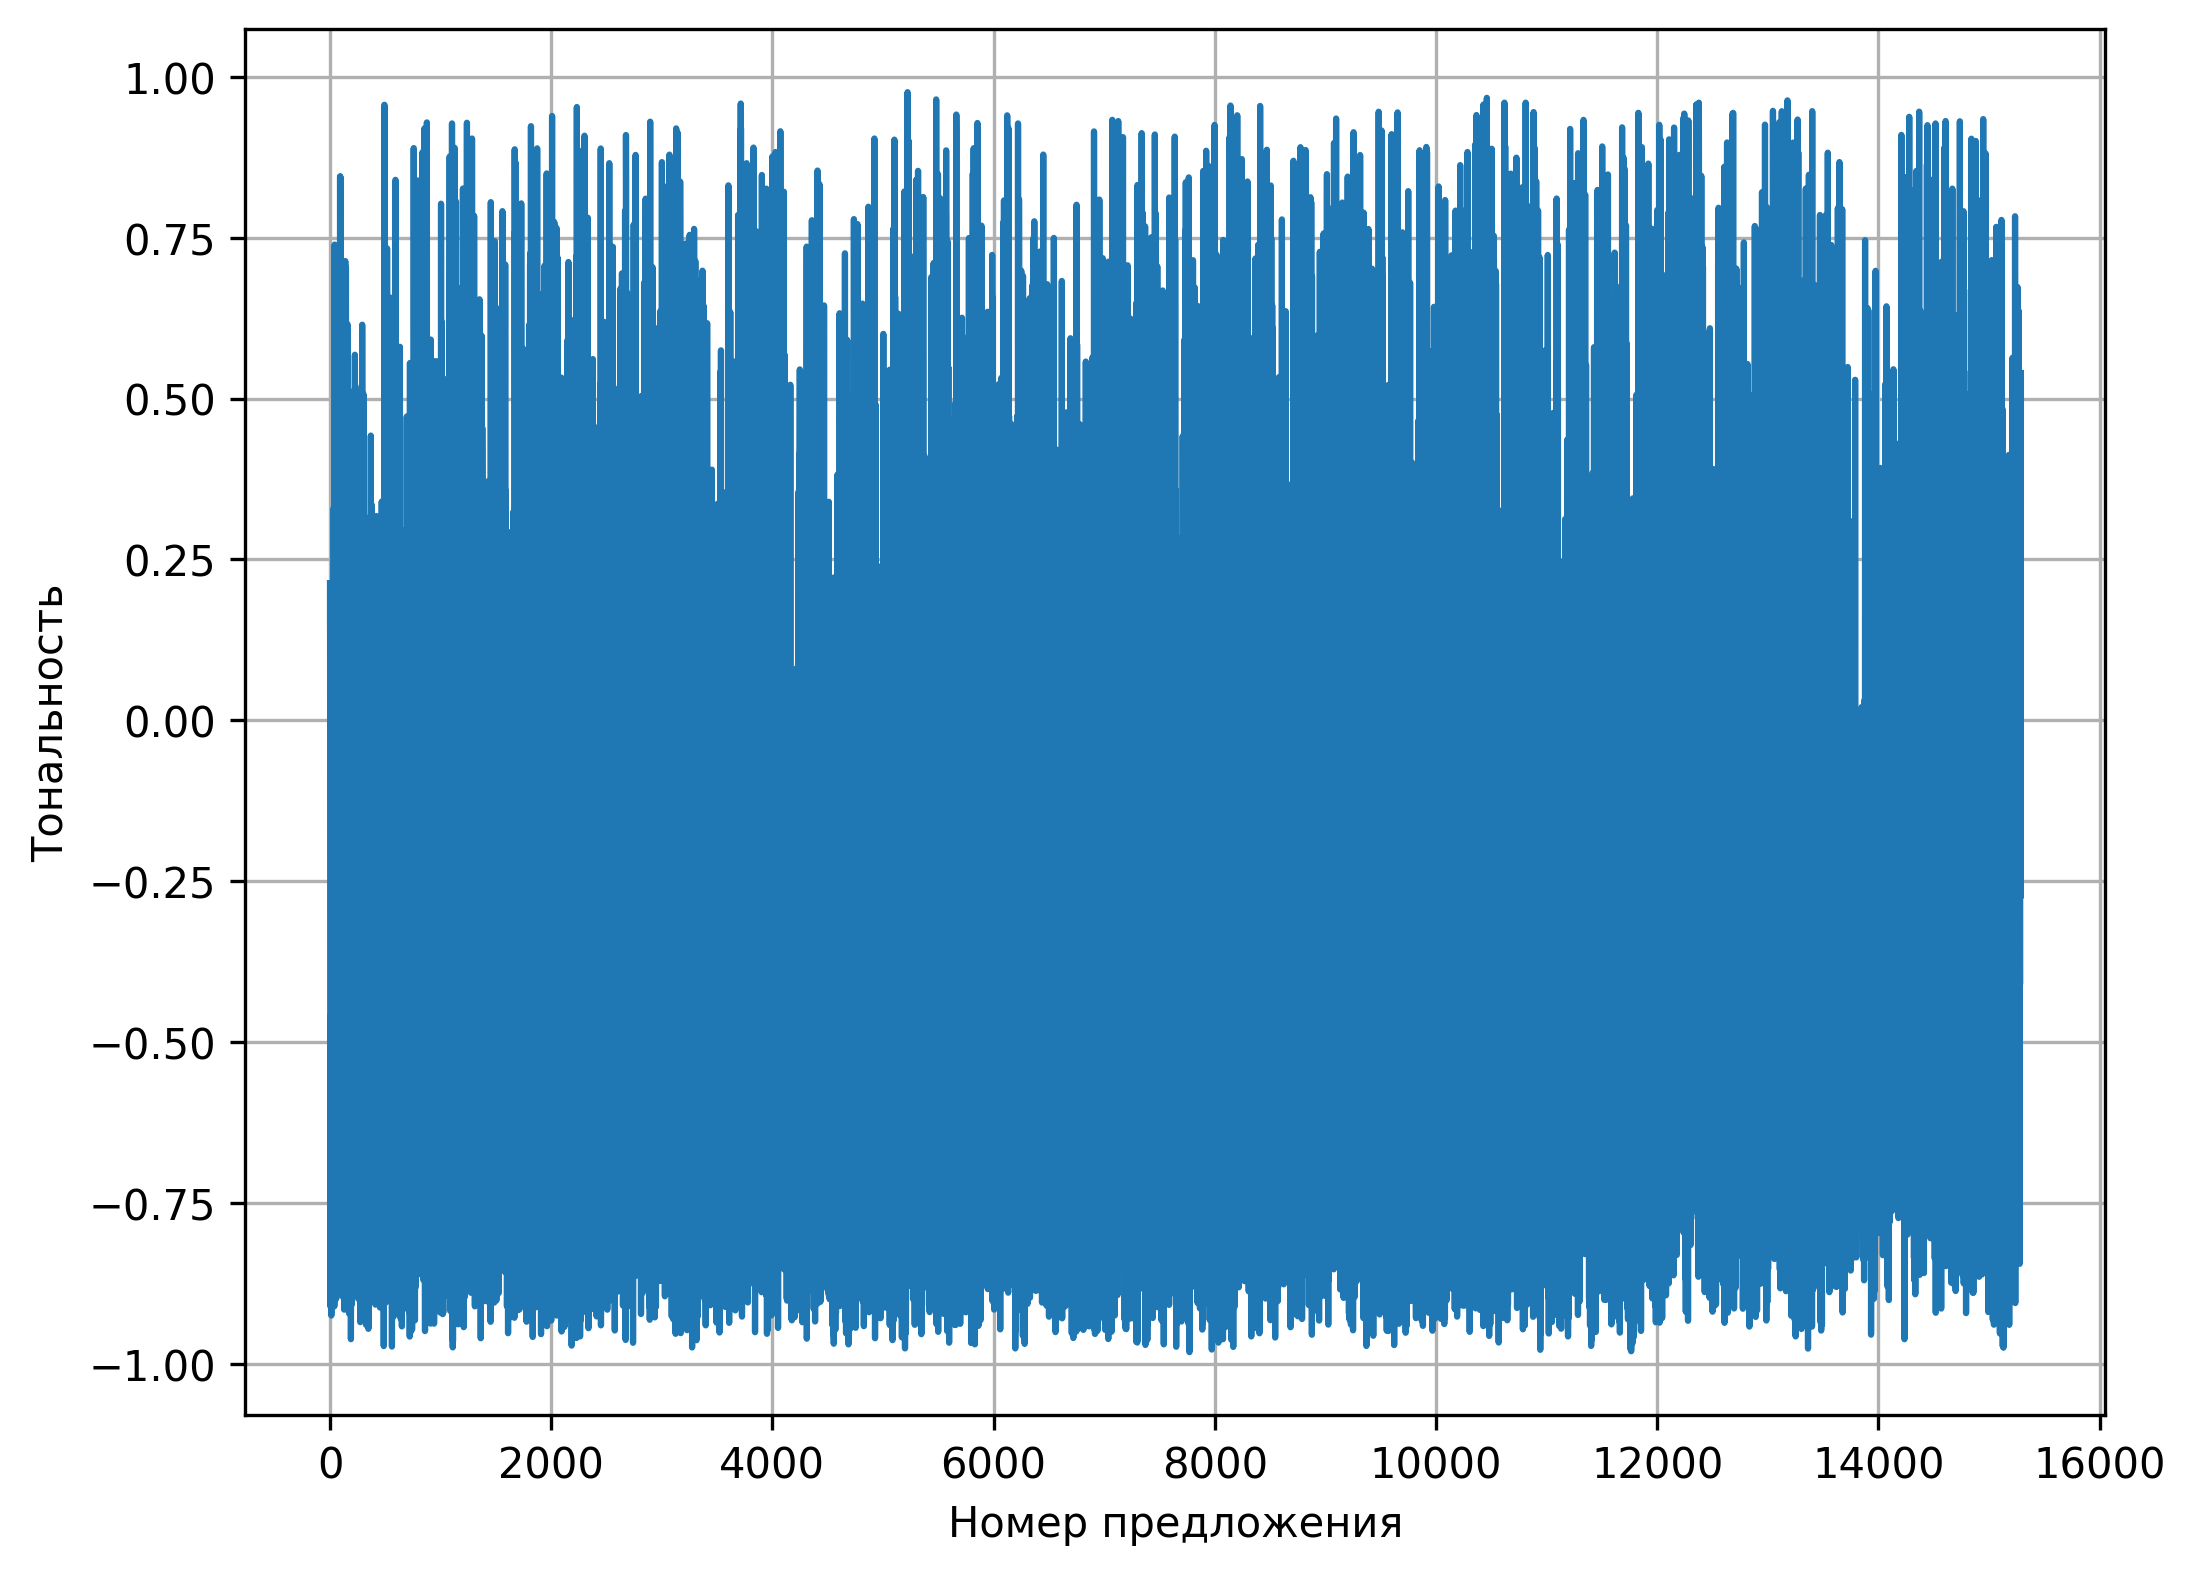

In [49]:
plt.figure(figsize=(8,6), dpi=300)
plt.plot(sentiments)
plt.xlabel('Номер предложения')
plt.ylabel('Тональность')
plt.grid()

Как-то сильно зашумлено получился график, форму даже не разглядеть, она искажена скачками и перепадами.

Тональность предложений внутри текста может испытывать резкие перепады, а сеть иногда ошибается, поэтому возникают шумы

Избавимся от шума с помощью фильтра Савицкого-Голея

Также, как вариант, брать за единицы не предложения, а главы, но подход не универсален и зависит от размера текста

In [50]:
filtered_sentiments = savgol_filter(sentiments, window_length=len(sentiments)//15, polyorder=0)

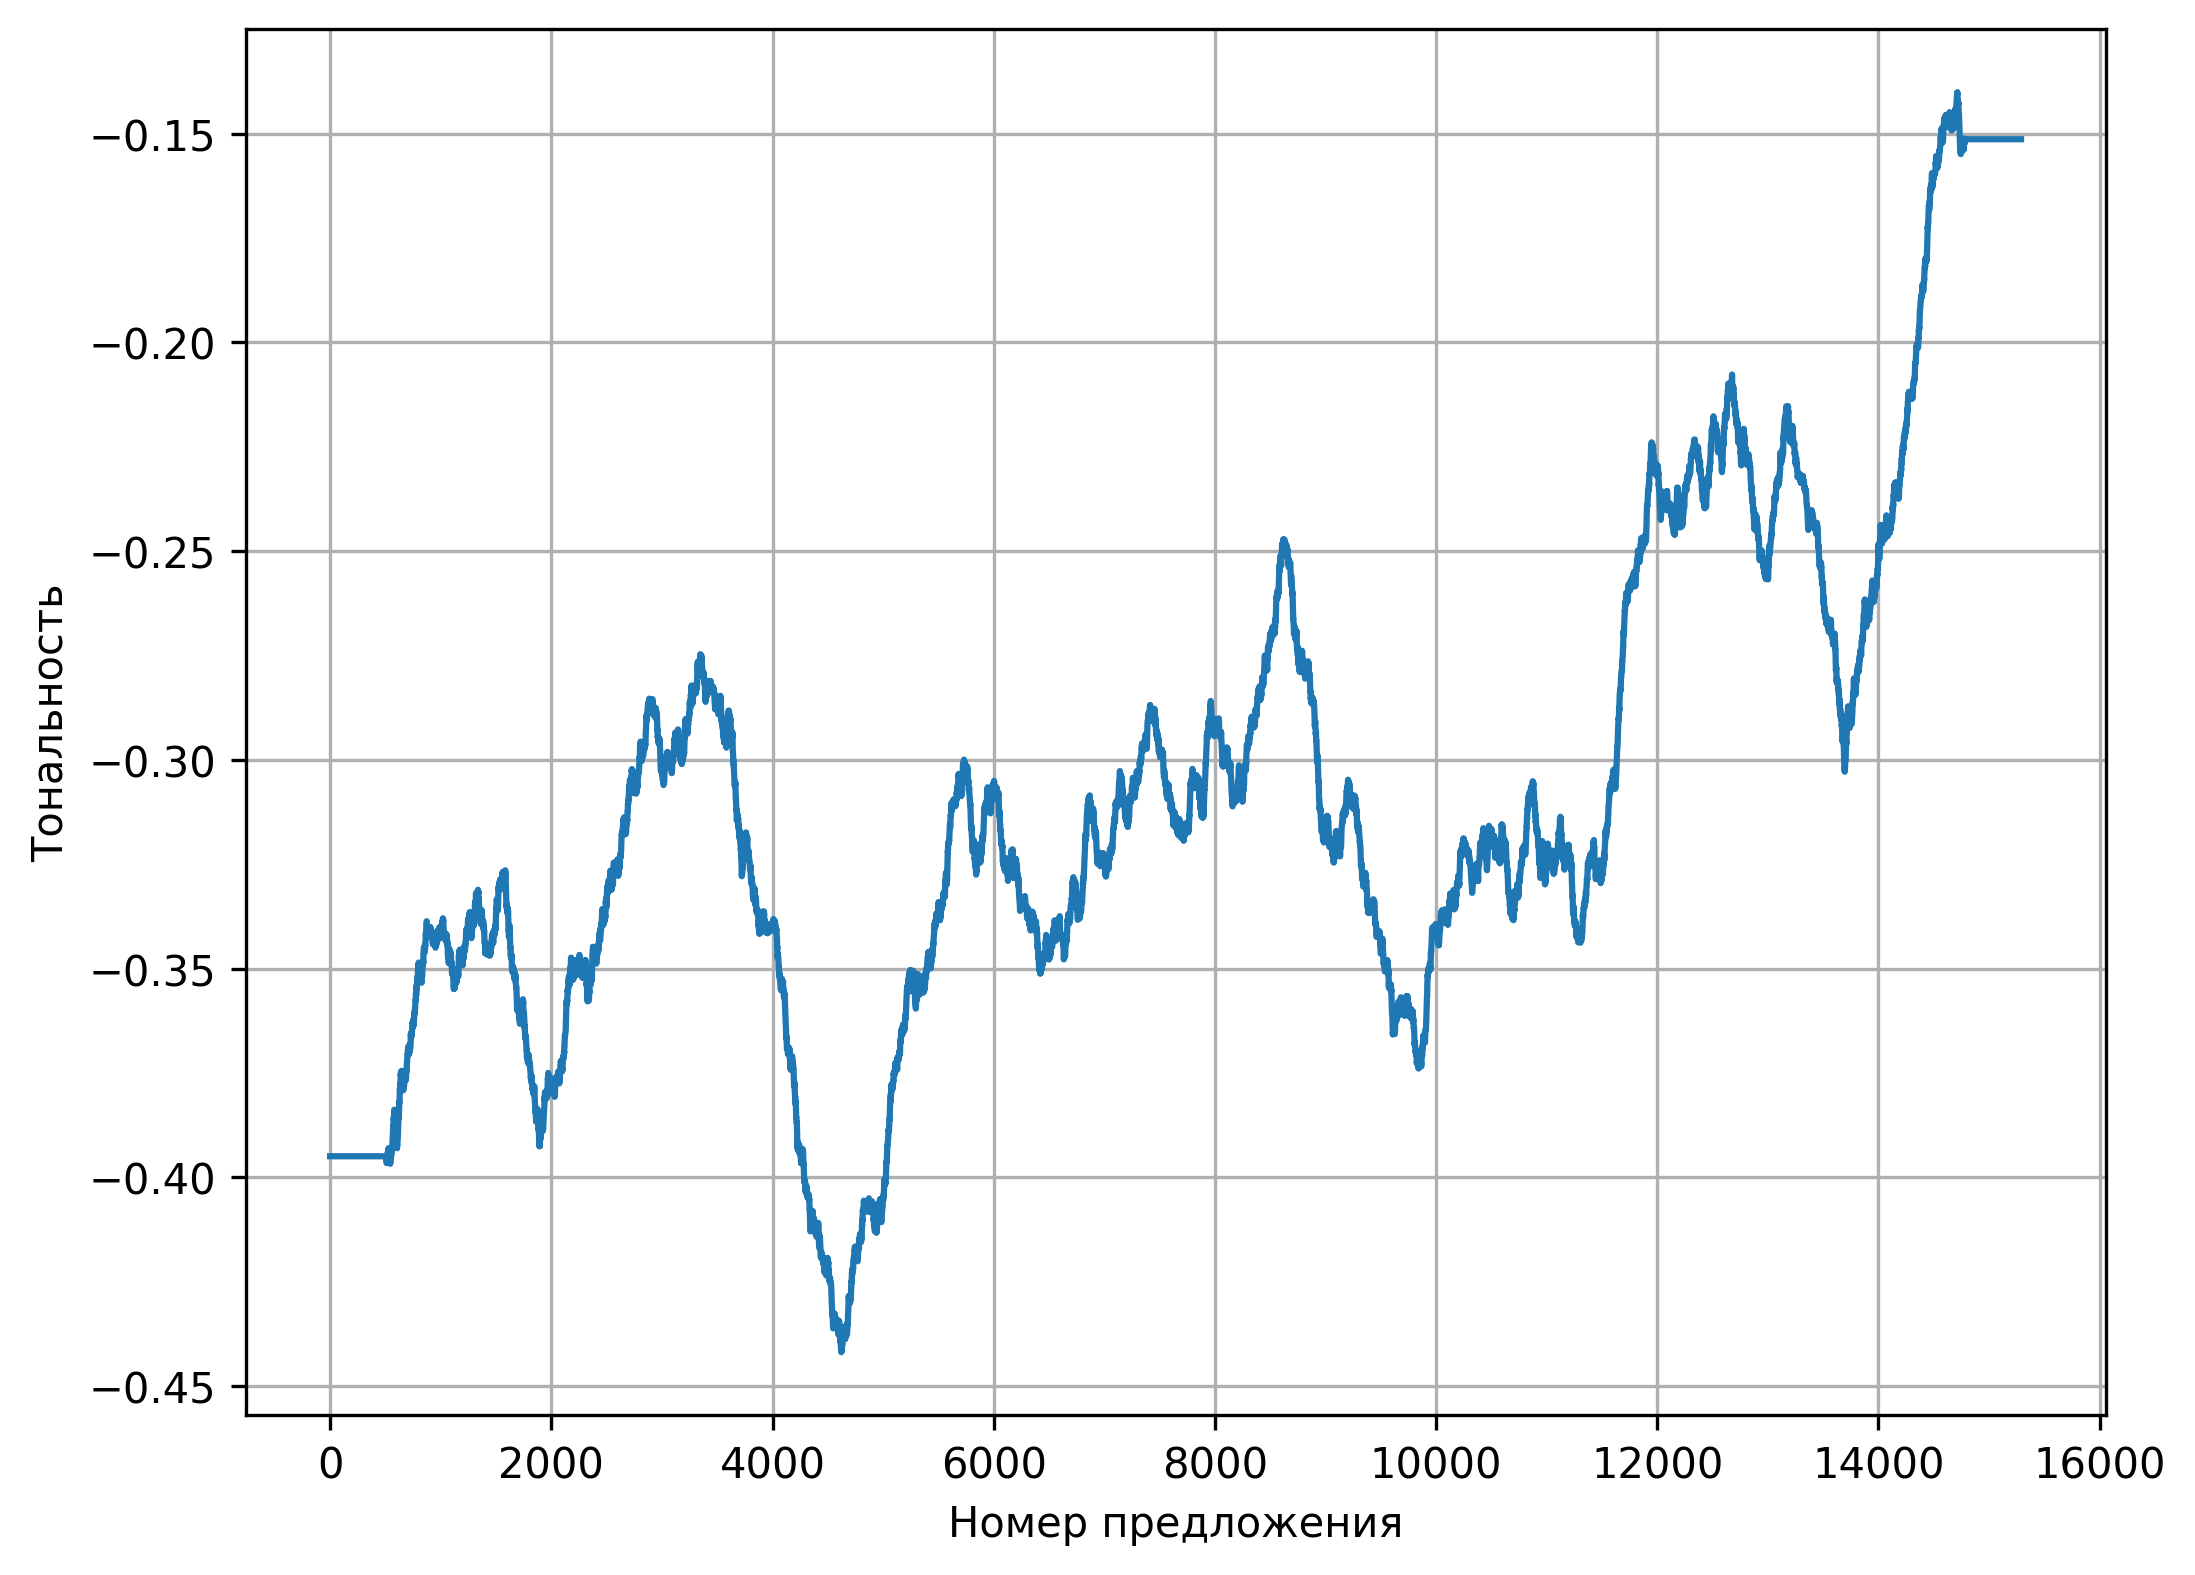

In [51]:
plt.figure(figsize=(8, 6), dpi=300)
plt.plot(filtered_sentiments)
plt.xlabel('Номер предложения')
plt.ylabel('Тональность')
plt.grid()

Выглядит лучше, но хочется получить более гладкую кривую, оставив тренды данного графика

Будем использовать ансамблевый фильтр. Обработаем параллельно зашумленную кривую несколькими фильтрами Савицкого-Голея с различным значением размера скользящего окна и усредним результаты всех фильтров. Наиболее значимые изгибы зашумленной исходной кривой окажутся наиболее устойчивыми к сглаживанию большинства фильтров и потому останутся в итоговом результате

n_filters - число фильтров

data - входной массив

In [52]:
def ensemble_filter(data: list, n_filters=100, polyorder=0, **savgol_args) -> list:
    filt = 0
    start = len(data)//10
    stop = len(data)//4
    step = (stop-start)//n_filters
    if step == 0:
        step = 1
    # меняем размер окна и усредняем итог
    for window_size in range(start, stop, step):
        res = savgol_filter(data, window_length=window_size, polyorder=polyorder, **savgol_args)
        filt += res
    return filt/n_filters

In [53]:
ensemble_filtered_sentiments = ensemble_filter(sentiments, polyorder=0)

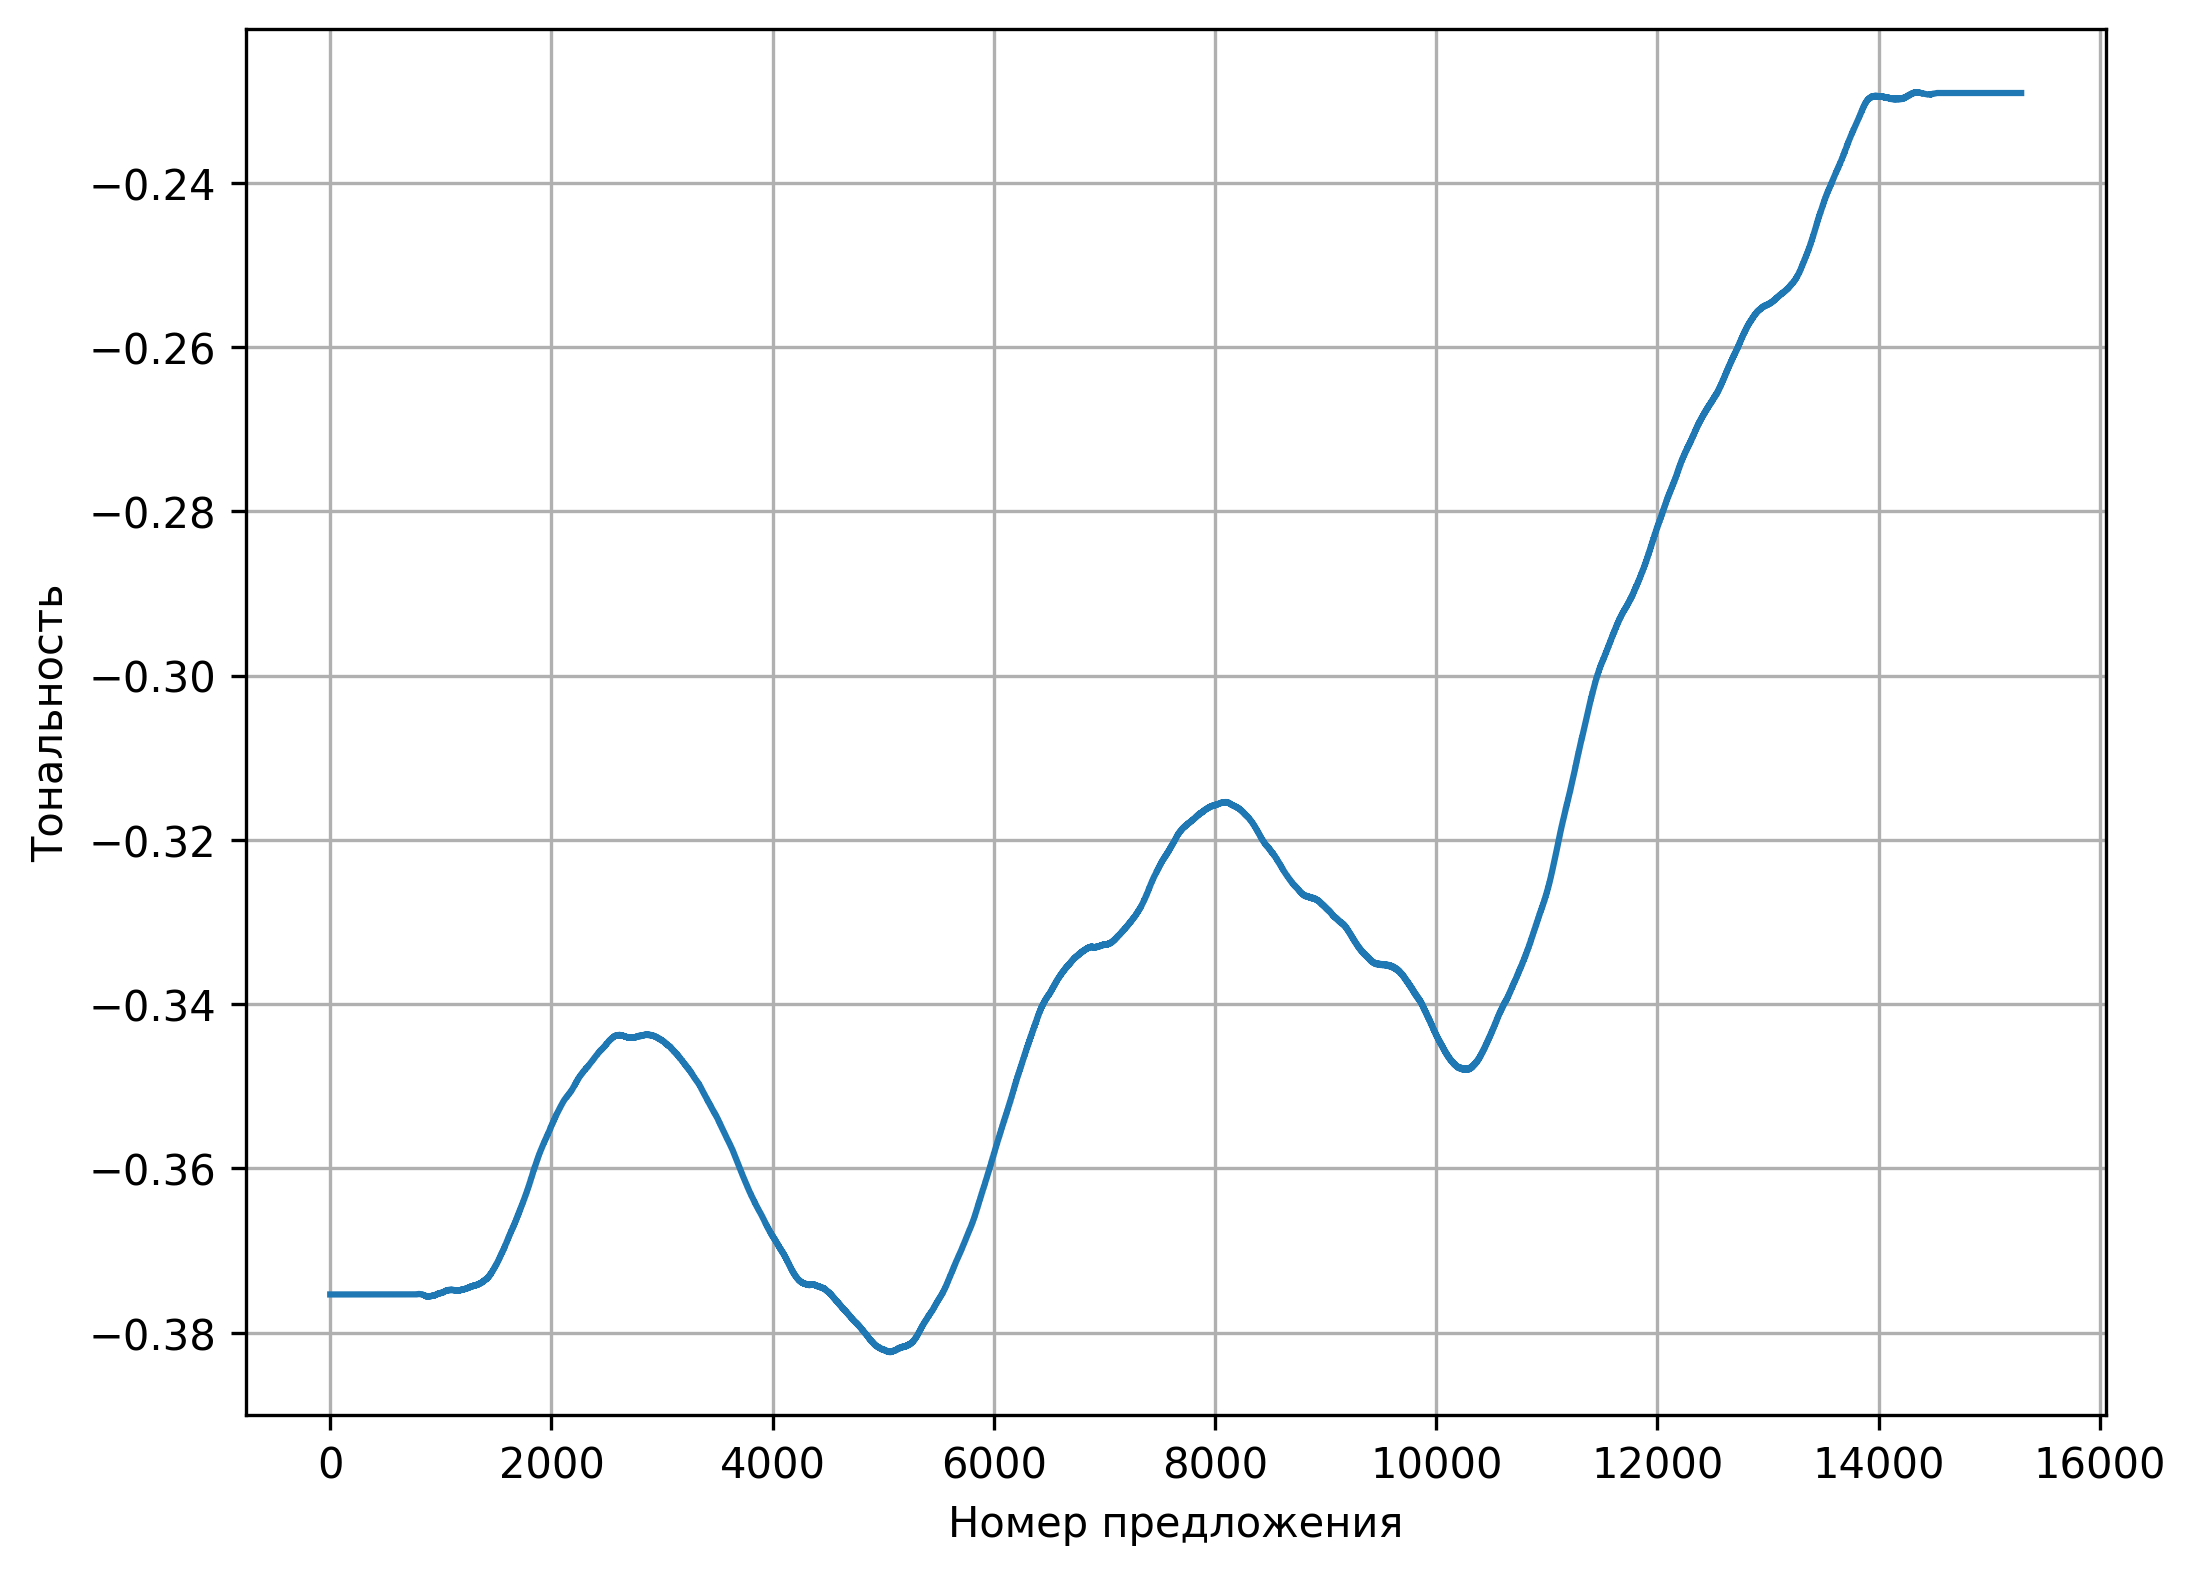

In [54]:
plt.figure(figsize=(8,6), dpi=300)
plt.plot(ensemble_filtered_sentiments)
plt.xlabel('Номер предложения')
plt.ylabel('Тональность')
plt.grid()